In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook

In [58]:
import geopandas as gpd
import pandas as pd

### Playground

In [9]:
import pghstore

In [3]:
OSM_extracted_roads_gdf = gpd.read_file('gmdata.nosync/GM_roads_1_extracted/GM_roads_1_extracted.shp')

In [74]:
other_tags_example = OSM_extracted_roads_gdf[OSM_extracted_roads_gdf.osm_id == '4018896']['other_tags'].iloc[0]
pghstore.loads(other_tags_example) # it seems that other_tags is HStore string from PostgreSQL

{'bicycle': 'no',
 'lanes': '1',
 'lit': 'yes',
 'maxspeed': '70 mph',
 'national_highways:area': '10',
 'oneway': 'yes',
 'operator': 'National Highways',
 'operator:wikidata': 'Q5760006',
 'ref': 'M60'}

In [99]:
def extract_tags(other_tags: str):
    if other_tags and not pd.isna(other_tags):
        other_tags = ','.join(list(filter(lambda x: x and x.count('"') == 4 and '=>' in x, other_tags.split(','))))
        try:
            tags = pghstore.loads(other_tags)
            return tags
        except ValueError as e:
            print(f'{other_tags=}', e)
    return None

In [100]:
def extract_lanes_number(other_tags: str, default_lanes_number: int = 1):
    tags = extract_tags(other_tags)
    if tags is not None:
        return int(tags.get('lanes', default_lanes_number))
    return default_lanes_number

In [109]:
def extract_max_speed(other_tags: str, default_max_speed: int = 50):
    tags = extract_tags(other_tags)
    if tags is not None:
        maxspeed_str = tags.get('maxspeed', None)
        if maxspeed_str is not None:
            try:
                maxspeed = int(maxspeed_str.split(' ')[0])
                if maxspeed > 0 and maxspeed < 200:
                    return maxspeed
            except ValueError as e:
                print(f'{maxspeed_str=}', e)
    return default_max_speed

In [75]:
def extract_lanes_number(other_tags: str, default_lanes_number: int = 1):
    if other_tags and not pd.isna(other_tags):
        other_tags = ','.join(list(filter(lambda x: x and x.count('"') == 4 and '=>' in x, other_tags.split(','))))
        try:
            tags = pghstore.loads(other_tags)
            return int(tags.get('lanes', default_lanes_number))
        except ValueError as e:
            print(f'{other_tags=}', e)
    return default_lanes_number

In [110]:
OSM_extracted_roads_gdf['max_speed'] = OSM_extracted_roads_gdf['other_tags'].apply(extract_max_speed)

maxspeed_str='GB:nsl_single' invalid literal for int() with base 10: 'GB:nsl_single'
maxspeed_str='GB:nsl_single' invalid literal for int() with base 10: 'GB:nsl_single'
maxspeed_str='GB:nsl_single' invalid literal for int() with base 10: 'GB:nsl_single'
maxspeed_str='GB:nsl_single' invalid literal for int() with base 10: 'GB:nsl_single'
maxspeed_str='GB:nsl_single' invalid literal for int() with base 10: 'GB:nsl_single'
maxspeed_str='GB:nsl_single' invalid literal for int() with base 10: 'GB:nsl_single'
maxspeed_str='GB:nsl_single' invalid literal for int() with base 10: 'GB:nsl_single'
maxspeed_str='GB:nsl_single' invalid literal for int() with base 10: 'GB:nsl_single'
maxspeed_str='GB:nsl_single' invalid literal for int() with base 10: 'GB:nsl_single'
maxspeed_str='GB:nsl_single' invalid literal for int() with base 10: 'GB:nsl_single'
maxspeed_str='GB:nsl_single' invalid literal for int() with base 10: 'GB:nsl_single'
maxspeed_str='GB:nsl_single' invalid literal for int() with base 

In [73]:
OSM_extracted_roads_gdf['lanes_number'] = OSM_extracted_roads_gdf['other_tags'].apply(extract_lanes_number)

<Axes: >

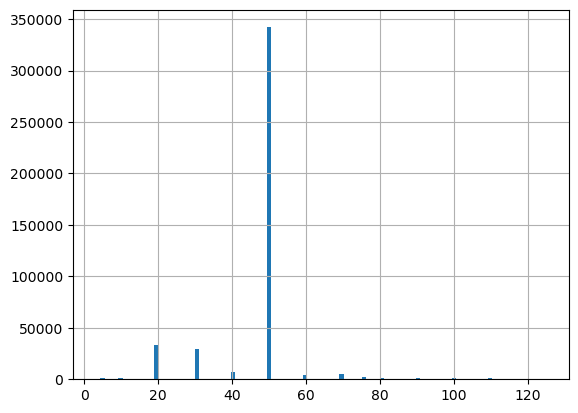

In [111]:
OSM_extracted_roads_gdf['max_speed'].hist(bins=100)

In [115]:
import matplotlib.pyplot as plt

(380000.0, 410000.0)

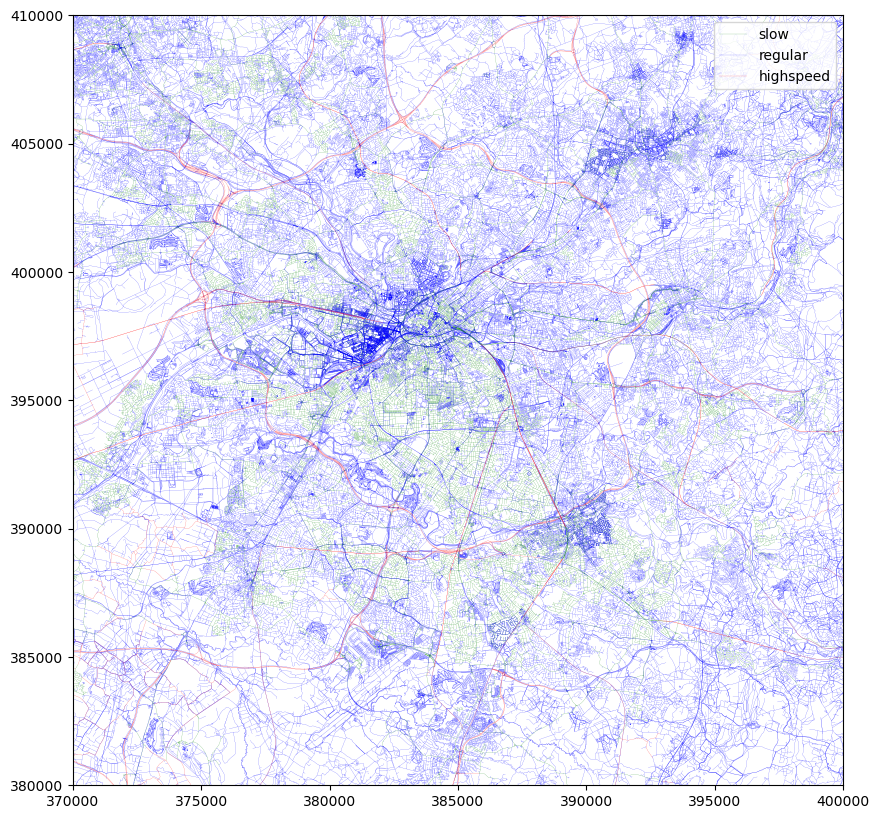

In [126]:
fig, ax = plt.subplots(figsize=(12,10))
OSM_extracted_roads_gdf[OSM_extracted_roads_gdf['max_speed'] < 50].plot(ax=ax, color='green', linewidth=0.1, label='slow')
OSM_extracted_roads_gdf[OSM_extracted_roads_gdf['max_speed'] == 50].plot(ax=ax, color='blue', linewidth=0.1, label='regular')
OSM_extracted_roads_gdf[OSM_extracted_roads_gdf['max_speed'] > 50].plot(ax=ax, color='red', linewidth=0.1, label='highspeed')
plt.legend()
ax.set_xlim(370000, 400000)
ax.set_ylim(380000, 410000)

<Axes: >

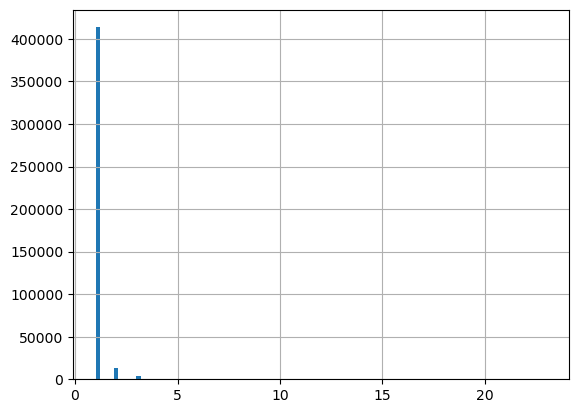

In [78]:
OSM_extracted_roads_gdf['lanes_number'].hist(bins=100)

(380000.0, 410000.0)

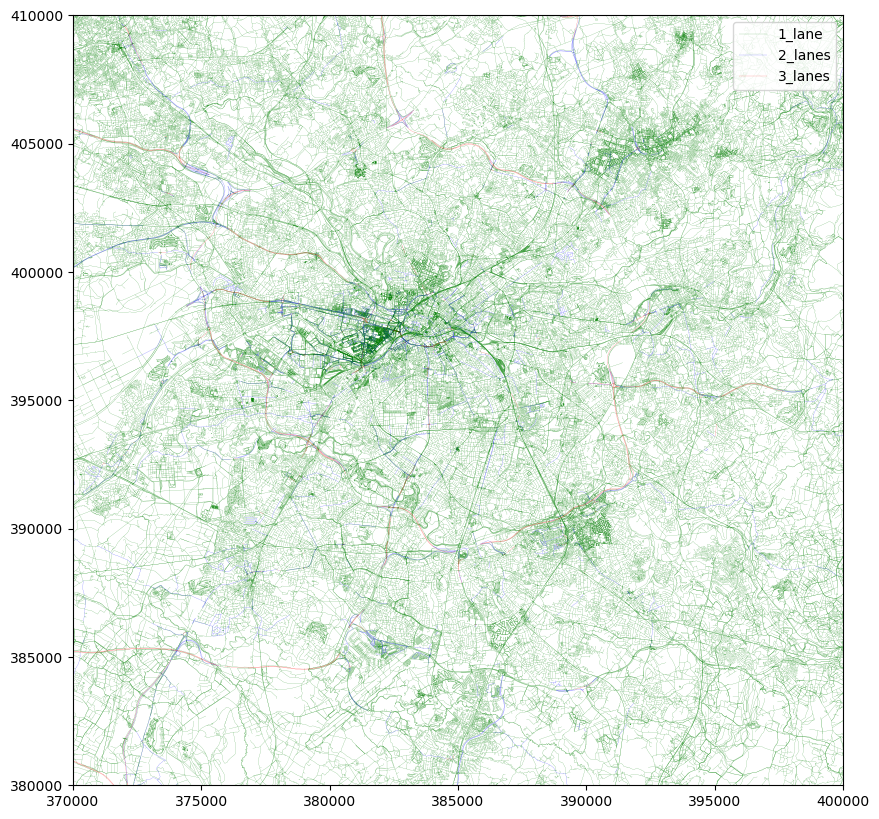

In [127]:
fig, ax = plt.subplots(figsize=(12,10))
OSM_extracted_roads_gdf[OSM_extracted_roads_gdf['lanes_number'] == 1].plot(ax=ax, color='green', linewidth=0.1, label='1_lane')
OSM_extracted_roads_gdf[OSM_extracted_roads_gdf['lanes_number'] == 2].plot(ax=ax, color='blue', linewidth=0.1, label='2_lanes')
OSM_extracted_roads_gdf[OSM_extracted_roads_gdf['lanes_number'] == 3].plot(ax=ax, color='red', linewidth=0.1, label='3_lanes')
plt.legend()
ax.set_xlim(370000, 400000)
ax.set_ylim(380000, 410000)

### Extraction and plots

In [79]:
OSM_extracted_roads_gdf = gpd.read_file('gmdata.nosync/GM_roads_1_extracted/GM_roads_1_extracted.shp')
OSM_extracted_roads_gdf['lanes_number'] = OSM_extracted_roads_gdf['other_tags'].apply(extract_lanes_number)
OSM_extracted_roads_gdf['max_speed'] = OSM_extracted_roads_gdf['other_tags'].apply(extract_max_speed)

In [79]:
len(OSM_extracted_roads_gdf)

431915

In [81]:
import numpy as np
import pandas as pd

In [82]:
good_highway_types = [
    'service', 'residential', 'unclassified', 'trunk', 'tertiary', 'primary', 'secondary', 'motorway', 'road', 'services',
    'trunk_link', 'motorway_link', 'primary_link', 'tertiary_link', 'living_street', 'secondary_link', 'busway'
]

In [249]:
OSM_extracted_roads_gdf[OSM_extracted_roads_gdf['osm_id'] == '119923533']

osm_id             name      highway waterway aerialway barrier  \
98023  119923533  Ashington Drive  residential      NaN       NaN     NaN   

      man_made railway  z_order other_tags  \
98023      NaN     NaN        3        NaN   

                                                geometry  our_highway  
98023  LINESTRING (377596.292 410471.066, 377611.491 ...  residential

In [83]:
from bim.gis import osm
streets_gdf = osm.Nominatim().load_streets_gdf()

In [84]:
streets_gdf

id               name  \
0           718463  Devonshire Street   
1           750748     Conyngham Road   
2           751336     Rusholme Place   
3           751405       Denison Road   
4           780145     Brighton Place   
...            ...                ...   
172241  1202290664                NaN   
172242  1202290665                NaN   
172243  1202290667                NaN   
172244  1202290668                NaN   
172245  1202290670                NaN   

                                                 geometry  LSOA_code  
0       LINESTRING (-2.21571 53.46883, -2.21581 53.468...  E01005063  
1       LINESTRING (-2.21896 53.45771, -2.21888 53.457...  E01005284  
2       LINESTRING (-2.22665 53.45764, -2.22648 53.457...  E01005244  
3       LINESTRING (-2.21340 53.45698, -2.21340 53.456...  E01005231  
4       LINESTRING (-2.23155 53.46528, -2.23114 53.46493)  E01005062  
...                                                   ...        ...  
172241  LINESTRING (-2.15029 53.53389, -2.15019 53.533...  E01005332  
172242  LINESTRING (-2.15025 53.53391, -2.15018 53.533...  E01005332  
172243  LINESTRING (-2.15022 53.53402, -2.15012 53.534...  E01005332  
172244  LINESTRING (-2.15020 53.53404, -2.15011 53.534...  E01005332  
172245  LINESTRING (-2.15013 53.53415, -2.15004 53.534...  E01005332  

[172246 rows x 4 columns]

In [85]:
# streets_gdf = osm.Nominatim().load_streets_gdf()
# streets_gdf.geometry.total_bounds
total_bounds = [353784.67760563, 381371.87809096, 404303.27216495, 421261.44411209]
xmin, ymin, xmax, ymax = total_bounds

In [128]:
OSM_extracted_roads_gdf

osm_id name   highway waterway aerialway barrier man_made railway  \
0             2282  NaN  motorway      NaN       NaN     NaN      NaN     NaN   
1             2306  NaN  motorway      NaN       NaN     NaN      NaN     NaN   
2             2310  NaN  motorway      NaN       NaN     NaN      NaN     NaN   
3             2314  NaN  motorway      NaN       NaN     NaN      NaN     NaN   
4             2317  NaN  motorway      NaN       NaN     NaN      NaN     NaN   
...            ...  ...       ...      ...       ...     ...      ...     ...   
431910  1202290664  NaN   service      NaN       NaN     NaN      NaN     NaN   
431911  1202290665  NaN   service      NaN       NaN     NaN      NaN     NaN   
431912  1202290667  NaN   service      NaN       NaN     NaN      NaN     NaN   
431913  1202290668  NaN   service      NaN       NaN     NaN      NaN     NaN   
431914  1202290670  NaN   service      NaN       NaN     NaN      NaN     NaN   

        z_order                                         other_tags  \
0            39  "bicycle"=>"no","bridge"=>"yes","bridge:name"=...   
1            39  "bicycle"=>"no","bridge"=>"yes","carriageway_r...   
2             9  "active_traffic_management"=>"yes","bicycle"=>...   
3             9  "active_traffic_management"=>"yes","bicycle"=>...   
4             9  "active_traffic_management"=>"yes","bicycle"=>...   
...         ...                                                ...   
431910        0          "access"=>"private","service"=>"driveway"   
431911        0          "access"=>"private","service"=>"driveway"   
431912        0          "access"=>"private","service"=>"driveway"   
431913        0          "access"=>"private","service"=>"driveway"   
431914        0          "access"=>"private","service"=>"driveway"   

                                                 geometry  lanes_number  \
0       LINESTRING (409485.269 290156.533, 409521.100 ...             3   
1       LINESTRING (409040.701 290819.521, 409113.845 ...             3   
2       LINESTRING (404367.006 294947.918, 404427.463 ...             4   
3       LINESTRING (405600.665 294369.433, 405504.770 ...             3   
4       LINESTRING (404374.733 294935.499, 404307.588 ...             4   
...                                                   ...           ...   
431910  LINESTRING (390135.575 404146.165, 390142.471 ...             1   
431911  LINESTRING (390138.668 404148.039, 390143.239 ...             1   
431912  LINESTRING (390140.794 404160.172, 390147.113 ...             1   
431913  LINESTRING (390141.687 404162.262, 390147.920 ...             1   
431914  LINESTRING (390146.374 404175.302, 390152.454 ...             1   

        max_speed  
0              70  
1              70  
2              70  
3              70  
4              70  
...           ...  
431910         50  
431911         50  
431912         50  
431913         50  
431914         50  

[431915 rows x 13 columns]

In [129]:
filtered_OSM_extracted_roads_gdf = OSM_extracted_roads_gdf[OSM_extracted_roads_gdf.highway.isin(good_highway_types)]

# inbox_index = filtered_OSM_extracted_roads_gdf.cx[xmin:xmax, ymin:ymax].index
# out_of_box_index = filtered_OSM_extracted_roads_gdf.index.difference(inbox_index)
# filtered_OSM_extracted_roads_gdf.loc[out_of_box_index].plot()

filtered_OSM_extracted_roads_gdf = filtered_OSM_extracted_roads_gdf.cx[xmin:xmax, ymin:ymax]

In [130]:
len(filtered_OSM_extracted_roads_gdf), len(OSM_extracted_roads_gdf)

(172246, 431915)

In [131]:
import gc
gc.collect(2)

73

In [90]:
from bim.gis.traffic.od_matrix import AreaOriginDestinationMatrix

In [91]:
from bim.gis import utils as gis_utils

In [137]:
new_streets_gdf = filtered_OSM_extracted_roads_gdf[['osm_id', 'name', 'geometry', 'lanes_number', 'max_speed']].copy()
new_streets_gdf.columns = ['id', 'name', 'geometry', 'num_lanes', 'max_speed']
new_streets_gdf.reset_index(drop=True, inplace=True)

In [317]:
# len(new_streets_gdf) / len(streets_gdf)

2.1427096421063108

In [138]:
area_od_matrix = AreaOriginDestinationMatrix()

In [139]:
new_streets_gdf = new_streets_gdf.to_crs(gis_utils.EPSG_WSG84)

In [140]:
new_streets_gdf[gis_utils.LSOA_CODE_COLUMN] = area_od_matrix.streets_geometry_to_lsoa(new_streets_gdf)

In [141]:
new_streets_gdf = new_streets_gdf.to_crs(gis_utils.EPSG_BNG)

In [142]:
gis_utils.EPSG_BNG

27700

In [143]:
new_streets_gdf

id               name  \
0           718463  Devonshire Street   
1           750748     Conyngham Road   
2           751336     Rusholme Place   
3           751405       Denison Road   
4           780145     Brighton Place   
...            ...                ...   
172241  1202290664                NaN   
172242  1202290665                NaN   
172243  1202290667                NaN   
172244  1202290668                NaN   
172245  1202290670                NaN   

                                                 geometry  num_lanes  \
0       LINESTRING (385777.562 396919.433, 385771.300 ...          1   
1       LINESTRING (385557.977 395682.743, 385563.479 ...          1   
2       LINESTRING (385047.967 395676.518, 385058.825 ...          1   
3       LINESTRING (385927.133 395600.123, 385927.042 ...          1   
4       LINESTRING (384725.088 396527.517, 384751.891 ...          1   
...                                                   ...        ...   
172241  LINESTRING (390135.575 404146.165, 390142.471 ...          1   
172242  LINESTRING (390138.668 404148.039, 390143.239 ...          1   
172243  LINESTRING (390140.794 404160.172, 390147.113 ...          1   
172244  LINESTRING (390141.687 404162.262, 390147.920 ...          1   
172245  LINESTRING (390146.374 404175.302, 390152.454 ...          1   

        max_speed  LSOA_code  
0              30  E01005063  
1              20  E01005284  
2              20  E01005244  
3              20  E01005231  
4              20  E01005062  
...           ...        ...  
172241         50  E01005332  
172242         50  E01005332  
172243         50  E01005332  
172244         50  E01005332  
172245         50  E01005332  

[172246 rows x 6 columns]

In [144]:
from shapely import wkt

In [146]:
# new_streets_gdf.set_geometry(new_streets_gdf['geometry'].apply(wkt.loads), inplace=True)

In [147]:
new_streets_gdf = new_streets_gdf.set_crs(gis_utils.EPSG_BNG, inplace=True)

In [148]:
new_streets_gdf = new_streets_gdf.to_crs(epsg=gis_utils.EPSG_WSG84)

In [149]:
gis_utils.save_geodf_to_csv(new_streets_gdf, 'gmdata.nosync/greater_manchester_streets_with_lsoa_fixed_tags.csv')

/opt/homebrew/anaconda3/envs/data-science-algorithms/lib/python3.8/site-packages/geopandas/geodataframe.py:1442: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [ ]:
# TODO: add num_lanes and max_speed columns to the gm_osm_fixed_base_model.json

In [444]:
new_streets_gdf2 = osm.Nominatim().load_streets_gdf('gmdata.nosync/greater_manchester_streets_with_lsoa_fixed.csv',
                                                   crs=4326)

In [394]:
def plot_and_save_congested_streets():
    streets = [
        "Mancunian Way",
        "City Centre",
        "Oxford Road",
        "Wilmslow Road",
        "Great Ancoats Street",
        "M60",
        "Cheetham Hill Road",
        "Ashton Road",
        "Ashton Old Road",
        "Bramhall Lane",
        "Princess Road",
        "Manchester Inner Ring Road",
        "Trinity Way",
        "A6",
        "Middleton Road",
        "Rochdale Road",
        "Chapel Street",
        "Trafford Road",
        "Bury New Road",
        "Manchester Quay Street",
        "M56",
        "Princes Parkway"
    ]

    congested_questionaire_gdf = new_streets_gdf[
        new_streets_gdf['name'].apply(lambda x: type(x) is str and any(s in x for s in streets))
    ]
    print(set(congested_questionaire_gdf['name']))

    fig, ax = plt.subplots()
    congested_questionaire_gdf.plot(ax=ax)
    for i in range(len(congested_questionaire_gdf)):
        row = congested_questionaire_gdf.iloc[i]
        p = row.geometry.coords[0]
    #     ax.text(int(p[0]), int(p[1]), row['name'], fontsize=5)

    import os
    os.makedirs('gmdata.nosync/congested_questionaire/')
    congested_questionaire_gdf.to_file('gmdata.nosync/congested_questionaire/congested_questionaire')

In [327]:
new_streets_gdf

id               name  \
0           718463  Devonshire Street   
1           750748     Conyngham Road   
2           751336     Rusholme Place   
3           751405       Denison Road   
4           780145     Brighton Place   
...            ...                ...   
172241  1202290664                NaN   
172242  1202290665                NaN   
172243  1202290667                NaN   
172244  1202290668                NaN   
172245  1202290670                NaN   

                                                 geometry LSOA_code  
0       LINESTRING (385777.562 396919.433, 385771.300 ...            
1       LINESTRING (385557.977 395682.743, 385563.479 ...            
2       LINESTRING (385047.967 395676.518, 385058.825 ...            
3       LINESTRING (385927.133 395600.123, 385927.042 ...            
4       LINESTRING (384725.088 396527.517, 384751.891 ...            
...                                                   ...       ...  
172241  LINESTRING (390135.575 404146.165, 390142.471 ...            
172242  LINESTRING (390138.668 404148.039, 390143.239 ...            
172243  LINESTRING (390140.794 404160.172, 390147.113 ...            
172244  LINESTRING (390141.687 404162.262, 390147.920 ...            
172245  LINESTRING (390146.374 404175.302, 390152.454 ...            

[172246 rows x 4 columns]

#### OSM edges investigation

In [234]:
rest_edges_df = OSM_extracted_roads_gdf[pd.isna(OSM_extracted_roads_gdf.highway)]
rest_edges_df = rest_edges_df[pd.isna(rest_edges_df['waterway'])]
rest_edges_df = rest_edges_df[pd.isna(rest_edges_df['aerialway'])]
rest_edges_df = rest_edges_df[pd.isna(rest_edges_df['barrier'])]
rest_edges_df = rest_edges_df[pd.isna(rest_edges_df['man_made'])]
rest_edges_df = rest_edges_df[pd.isna(rest_edges_df['railway'])]
rest_edges_df = rest_edges_df[rest_edges_df['other_tags']\
                              .apply(lambda x: not (type(x) is str and (
    'coastline' in x or 
    'aeroway' in x or
    'admin_level' in x or
    'removed' in x or
    'golf' in x or 
    'voltage' in x or
    'disused' in x or
    'demolished' in x or 
    'addr:' in x or
    'abandoned' in x or
    'boundary' in x or 
    'historic' in x or
    'power' in x or 
    'natural' in x or
    'gasometer' in x or 
    'embankment' in x or
    'building' in x
)))]
rest_edges_df = rest_edges_df[~pd.isna(rest_edges_df['other_tags'])]

In [238]:
# 

In [239]:
# print("\n".join(rest_edges_df[:50]['other_tags']))

In [240]:
len(rest_edges_df), len(OSM_extracted_roads_gdf[pd.isna(OSM_extracted_roads_gdf.highway)])

(1194, 100350)

In [116]:
OSM_extracted_roads_gdf['our_highway'] = OSM_extracted_roads_gdf['highway'].copy()
OSM_extracted_roads_gdf.loc[pd.isna(OSM_extracted_roads_gdf['our_highway']), 'our_highway'] = 'unknown'

def top_highway_osm_types():
    return OSM_extracted_roads_gdf.groupby('our_highway')\
        .agg({'osm_id': 'count'}).sort_values('osm_id', ascending=False)

In [105]:
# OSM_extracted_roads_gdf.iloc[[True, False, True]]

In [180]:
# OSM_extracted_roads_gdf.groupby('man_made').agg({'osm_id': 'count'}).sort_values('osm_id', ascending=False)

In [120]:
# set(OSM_extracted_roads_gdf['highway'])

In [128]:
# OSM_extracted_roads_gdf[OSM_extracted_roads_gdf['highway'] == 'motorway']

In [155]:
# OSM_extracted_roads_gdf[OSM_extracted_roads_gdf.man_made == 'bridge']

In [ ]:
edges_df = sumo_network.make_edges_df()

<IPython.core.display.Javascript object>


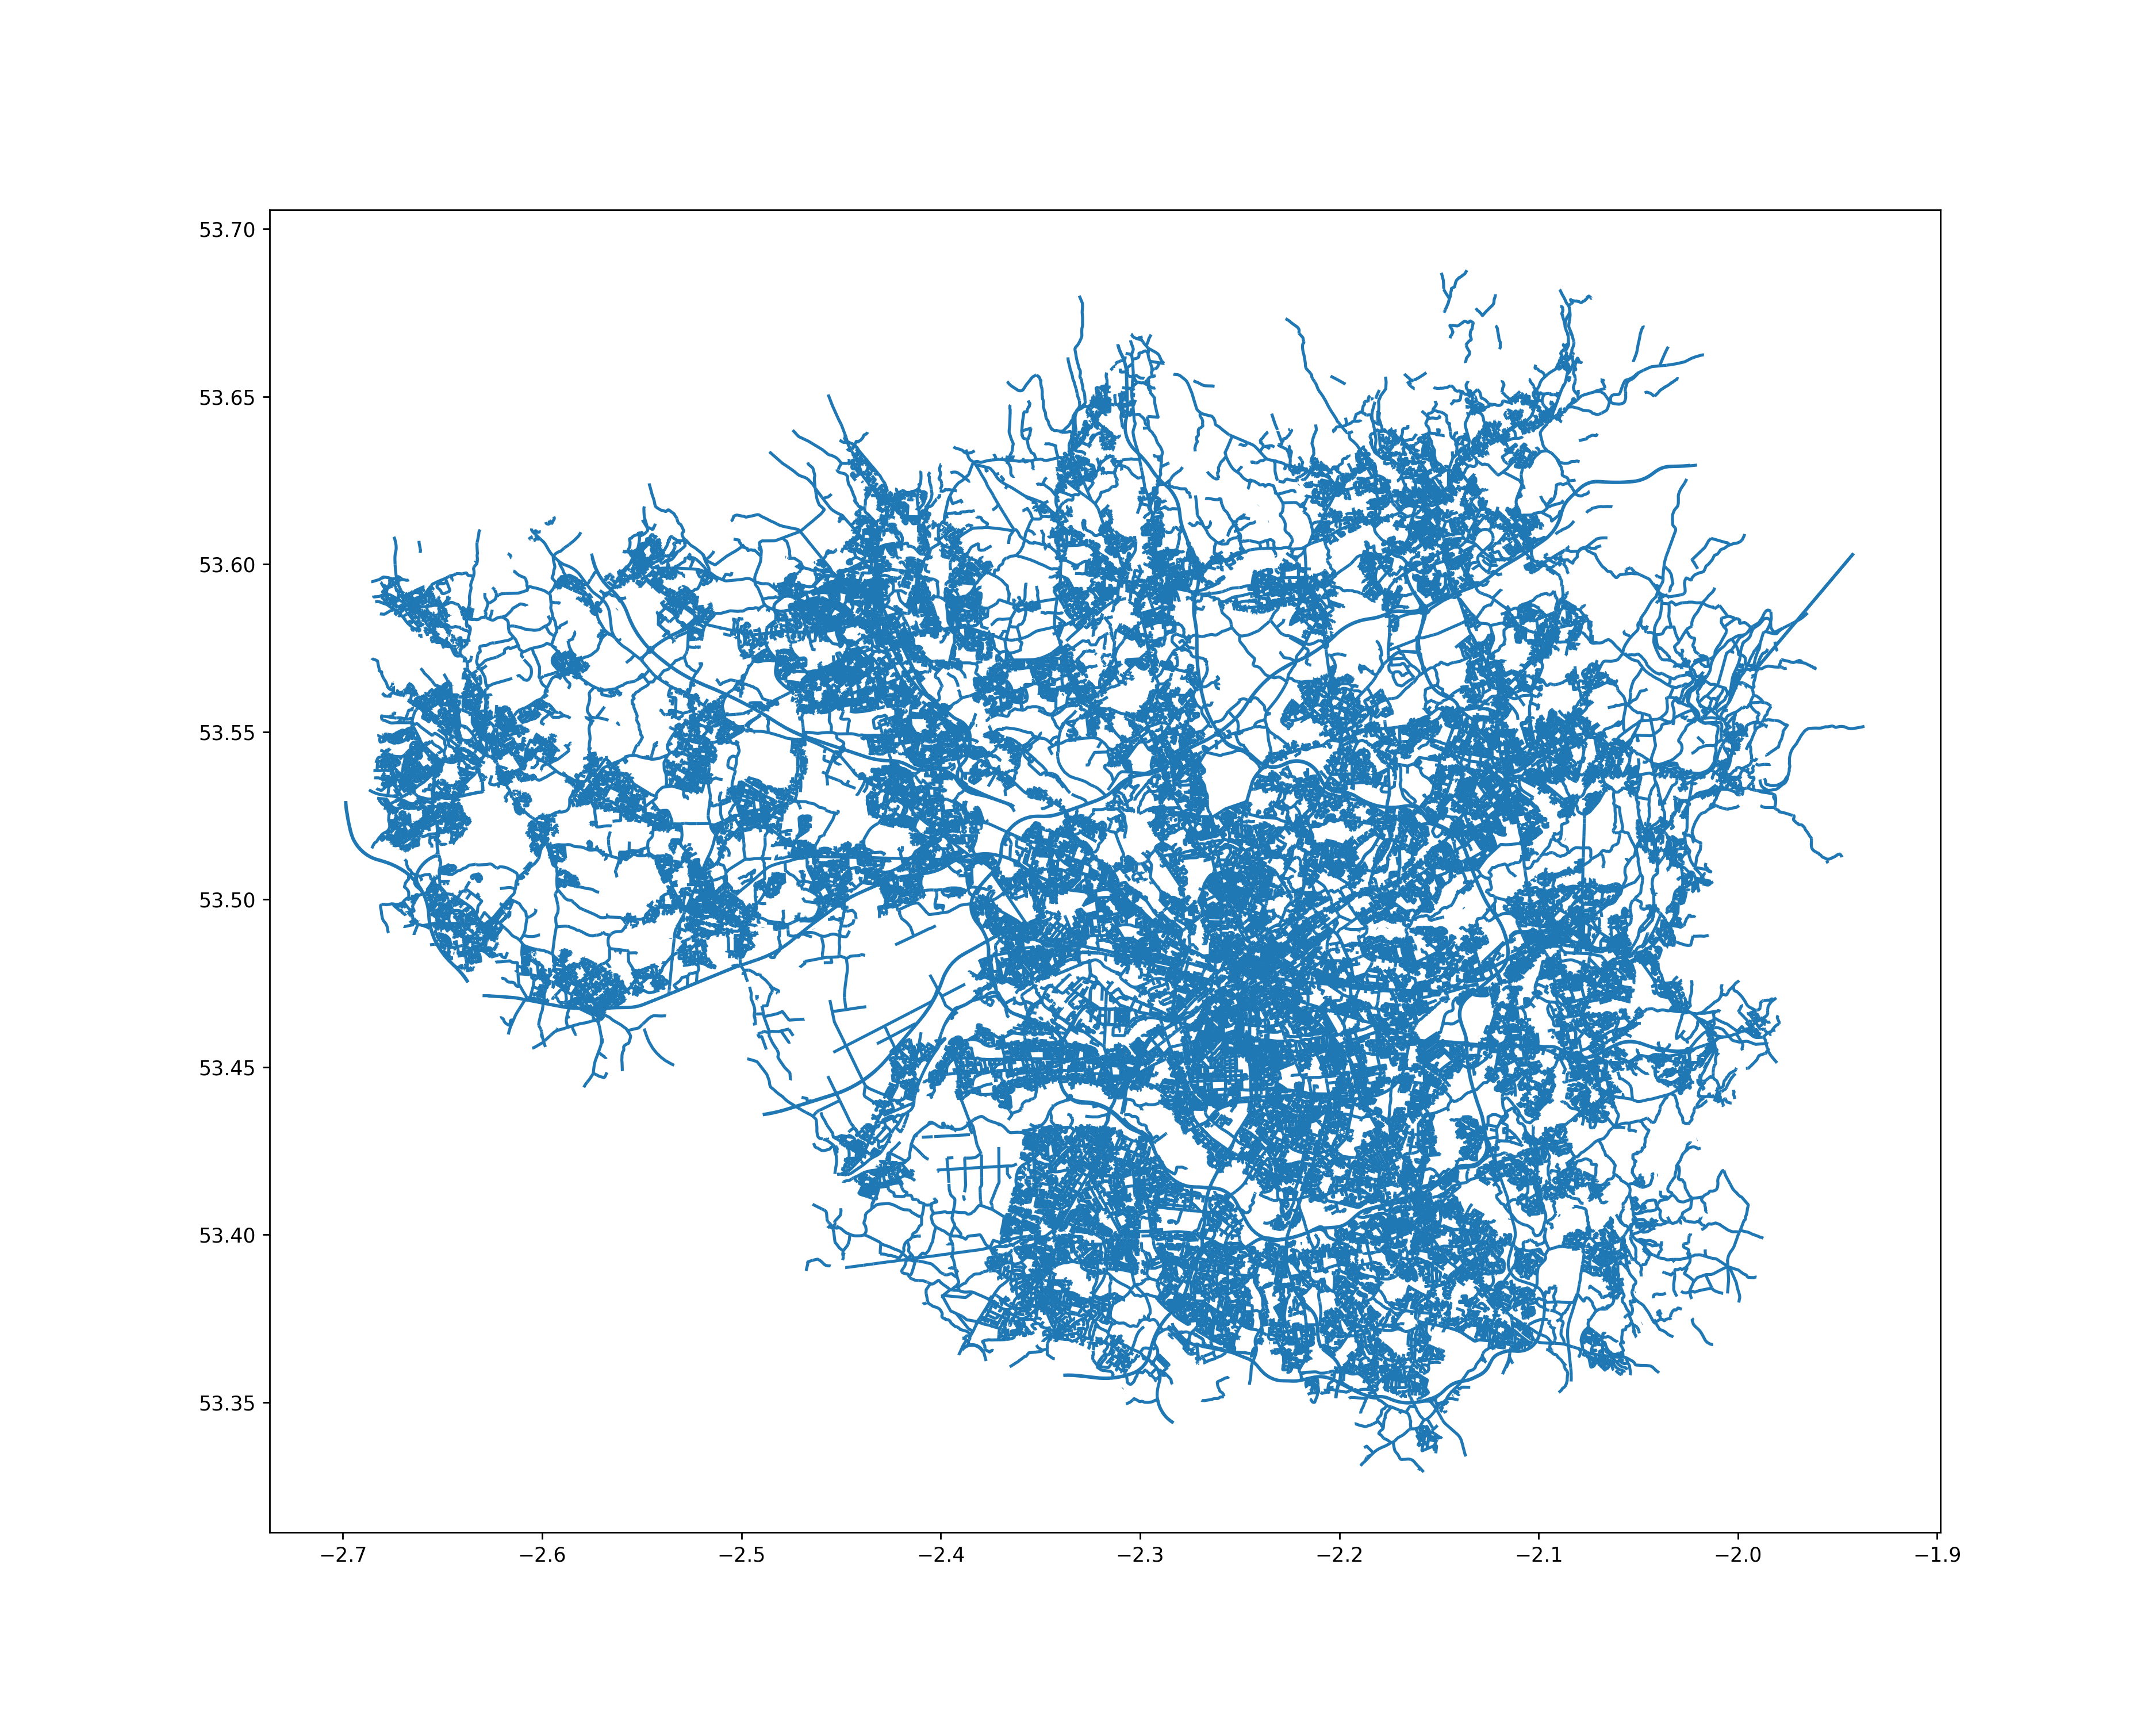

<Axes: >

In [244]:
streets_gdf.plot(figsize=(15,12))

In [251]:
OSM_extracted_roads_gdf[OSM_extracted_roads_gdf.osm_id == '119923533']

osm_id             name      highway waterway aerialway barrier  \
98023  119923533  Ashington Drive  residential      NaN       NaN     NaN   

      man_made railway  z_order other_tags  \
98023      NaN     NaN        3        NaN   

                                                geometry  our_highway  
98023  LINESTRING (377596.292 410471.066, 377611.491 ...  residential

In [248]:
OSM_extracted_roads_gdf[OSM_extracted_roads_gdf.osm_id == '4018896']

osm_id name        highway waterway aerialway barrier man_made railway  \
2378  4018896  NaN  motorway_link      NaN       NaN     NaN      NaN     NaN   

      z_order                                         other_tags  \
2378        9  "bicycle"=>"no","lanes"=>"1","lit"=>"yes","max...   

                                               geometry    our_highway  
2378  LINESTRING (382612.648 391034.597, 382612.287 ...  motorway_link

In [272]:
streets_gdf = streets_gdf.to_crs(27700)

<IPython.core.display.Javascript object>


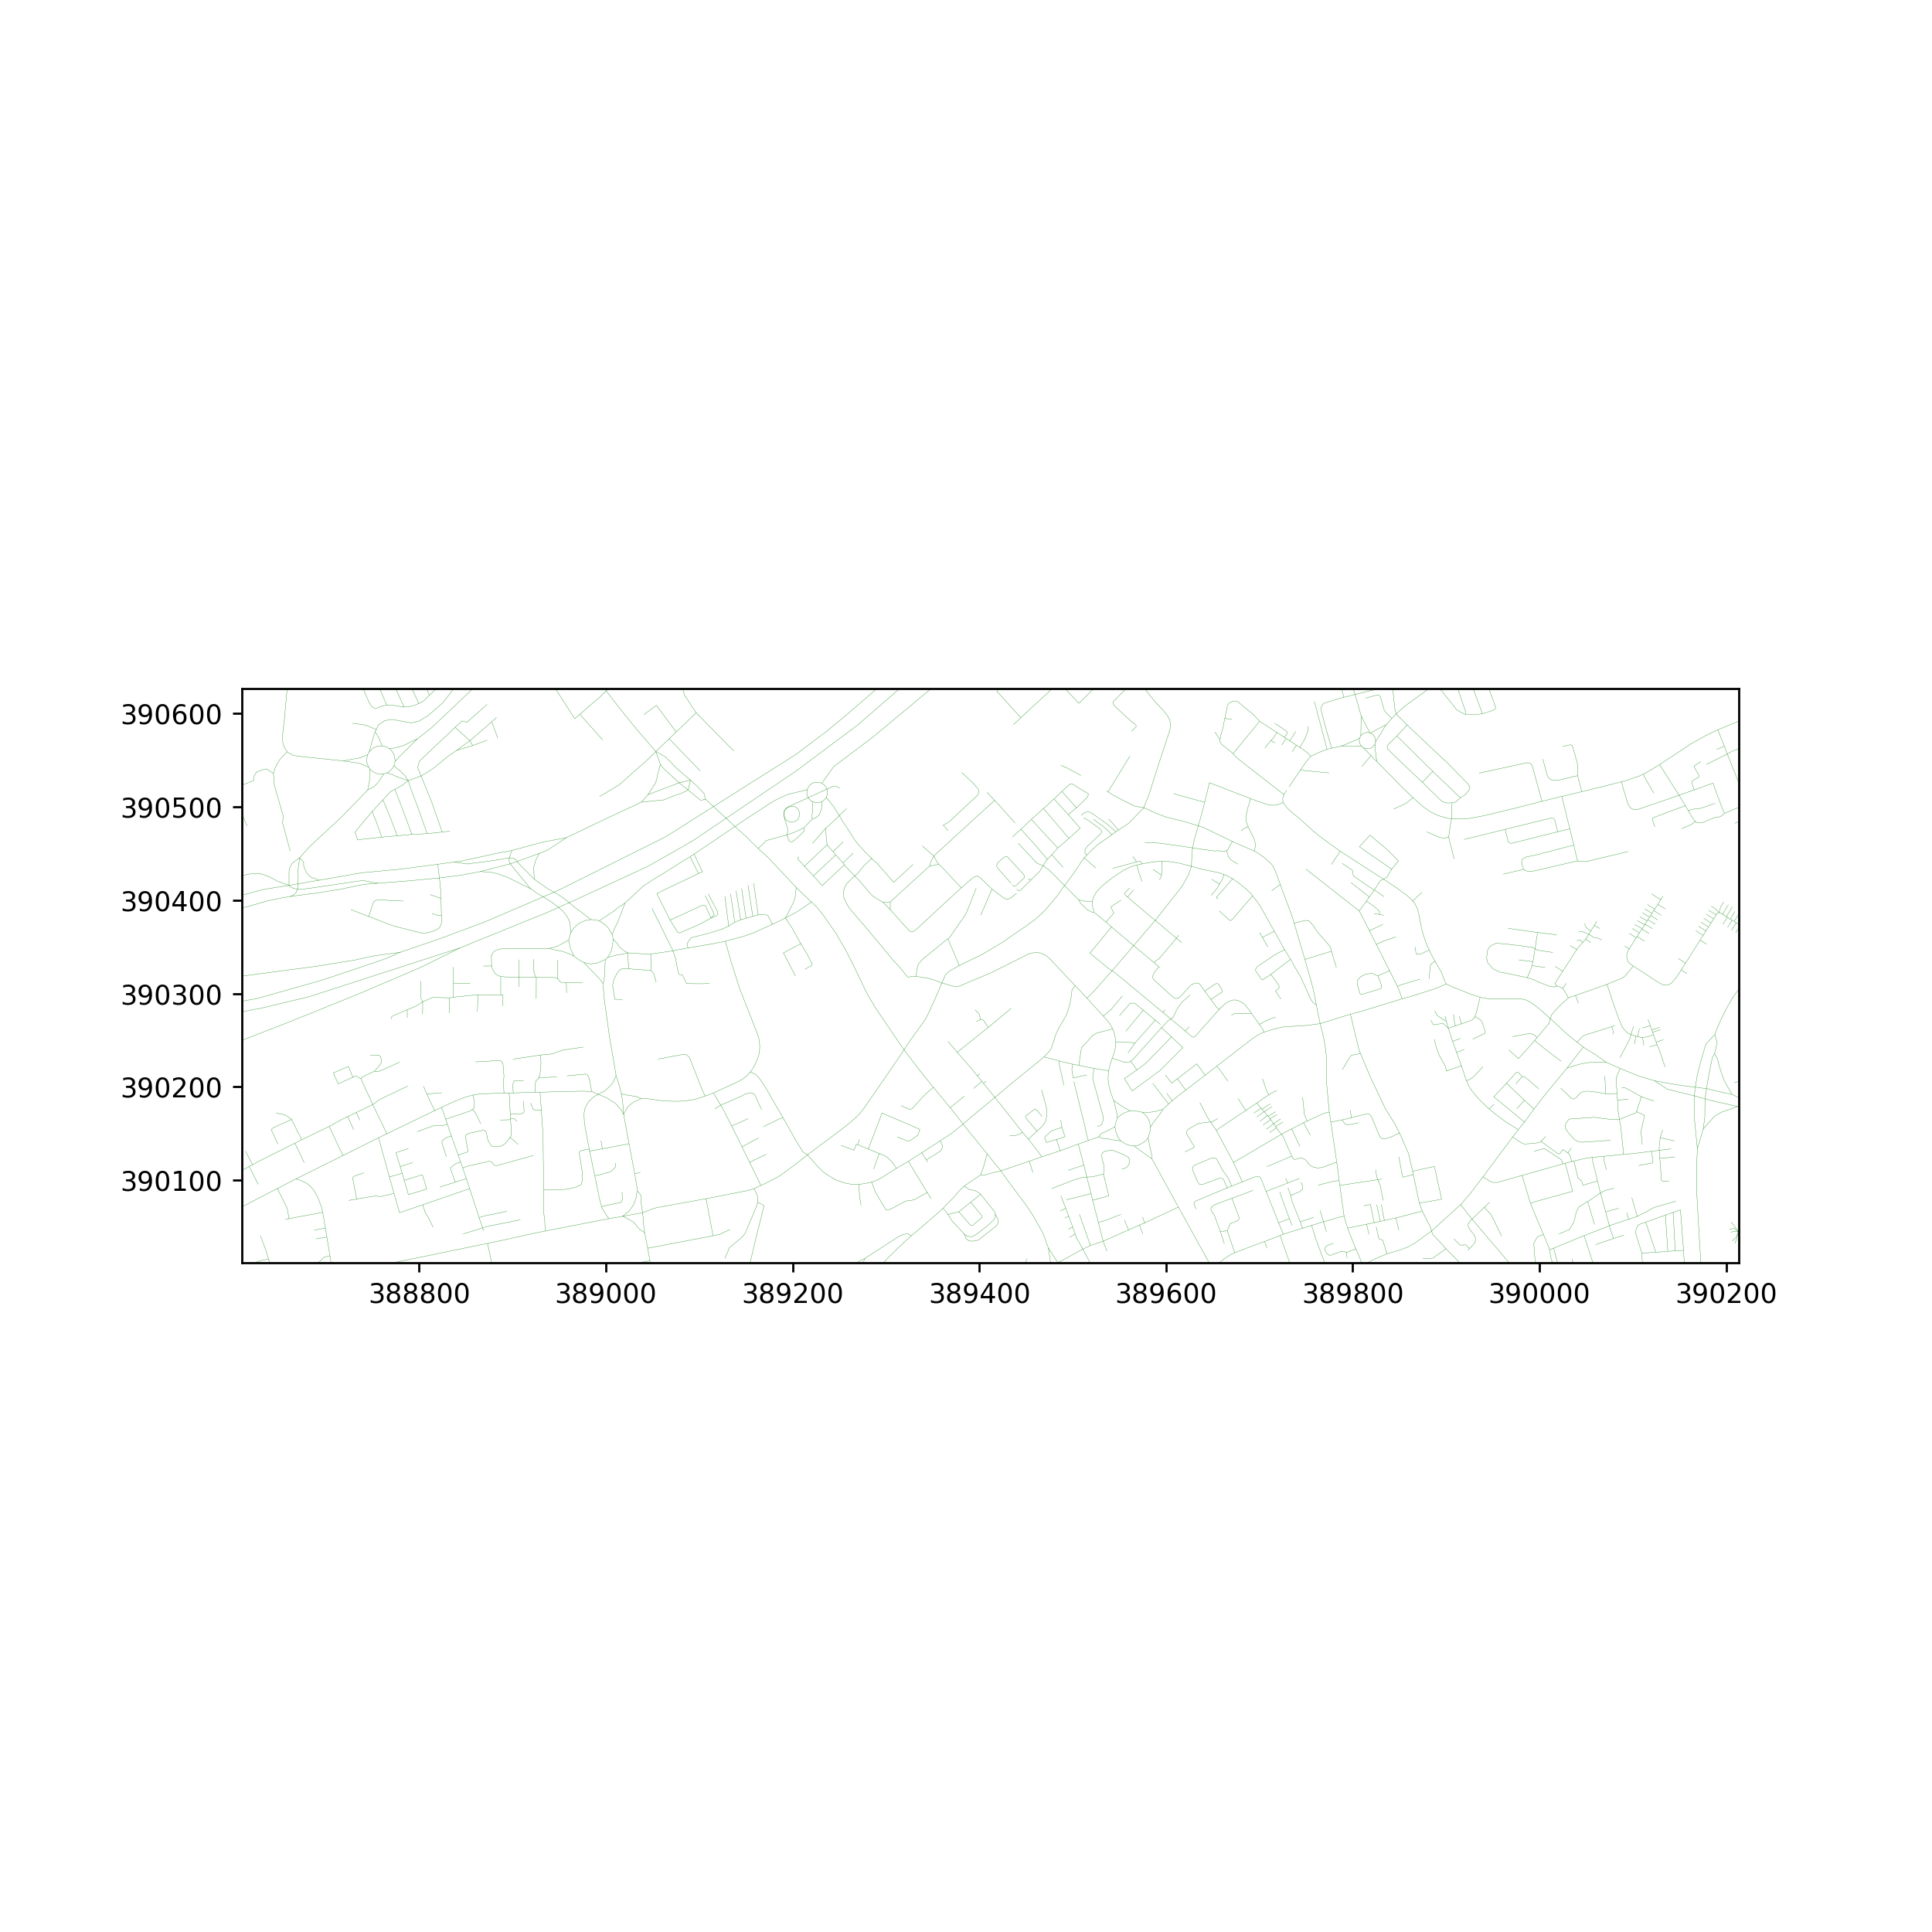

[]

In [310]:
import matplotlib.pyplot as plt
# random_indices = np.random.randint(0,len(OSM_extracted_roads_gdf), size=10000)
fig, ax = plt.subplots(figsize=(10,10))
filtered_OSM_extracted_roads_gdf.plot(ax=ax, color='green', linewidth=0.1)
# streets_gdf.plot(ax=ax, linewidth=4, alpha=0.5, color='red')
# OSM_extracted_roads_gdf[OSM_extracted_roads_gdf.man_made == 'bridge'].plot(ax=ax, color='green')

# ax.set_xlim(377200, 378400)
# ax.set_ylim(393400, 394200)
plt.plot()